# Biomarker Identification

In [111]:
# adding the project root inside the python path
import sys
import os

sys.path.insert(0, os.path.abspath('..'))

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from analysis.preprocess import PreprocessPipeline

In [113]:
pipeline = PreprocessPipeline(
    datasets_path='../../dataset/first_disease_sel',
    disease_col_name='DISEASE',
    output_dir='/tmp/chl/',
)

pipeline.execute_pipeline()
df = pipeline.dataset

INFO:root:Starting pipeline
INFO:root:Loading datasets
INFO:root:Skipping file ../../dataset/first_disease_sel/.DS_Store
INFO:root:Inspecting directory ../../dataset/first_disease_sel/GS
INFO:root:Setting disease as GS
INFO:root:Loading file ../../dataset/first_disease_sel/GS/eGSE117146m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/NALD
INFO:root:Setting disease as NALD
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE34308m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE117647m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE85804m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/A1A
INFO:root:Setting disease as A1A
INFO:root:Loading file ../../dataset/first_disease_sel/A1A/A1A_deficiency_GSE109516_pbmc.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/DIABETE
INFO:root:Setting disease as DIABETE
INFO:root:Loading file ../../dataset/first_disease_sel/DIABETE/eGSE27949m.csv


In [114]:
pipeline.test_set

,MAN2B1,SBNO2,WDR73,PIAS1,KDM4A,RCBTB2,ACTN4,ISOC2,RIF1,NCBP1,...,USP32,ZNF81,PRSS23,BIRC2,VAMP5,DMD,TUBB2B,IL15,STARD7,GTF3A
97,0.173162,0.134645,0.533475,0.623321,0.524867,0.454112,0.250031,0.414955,0.359126,0.173335,...,0.368493,0.368341,0.783044,0.323342,0.304725,0.062306,0.024157,0.379702,0.553377,0.391447
292,0.677497,0.255270,0.924188,0.440694,0.894161,0.508830,0.351036,0.489796,0.749169,0.402920,...,0.482602,0.497758,0.566489,0.397474,0.106113,1.000000,0.000000,0.731225,0.576973,1.000000
344,0.493151,0.247423,0.619048,0.812030,0.232323,0.500000,0.124183,0.013158,0.755556,0.686747,...,0.611765,0.878378,1.000000,0.784483,0.609375,0.372372,0.626409,0.559846,0.242647,0.597015
64,0.042192,0.888331,0.677081,0.465241,0.480442,0.233349,0.528899,0.115080,0.714103,1.000000,...,0.625022,1.000000,0.370560,0.294695,0.000000,0.442406,0.581256,0.051338,1.000000,1.000000
91,0.601091,0.420758,0.485473,0.376558,0.743237,0.257057,0.545512,0.623994,0.169277,0.101355,...,0.236547,0.142378,0.380304,0.189633,0.370133,0.137938,0.047712,0.253088,0.279619,0.380786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.224277,0.276241,0.701454,0.657055,0.500983,0.515963,0.151205,0.169382,0.407561,0.247938,...,0.578931,0.452273,0.073570,0.383746,0.108216,0.061780,0.011644,0.404851,0.647209,0.386732
41,0.669968,0.399160,0.734359,0.446791,0.000000,1.000000,0.834157,0.398472,0.651416,0.481256,...,0.164764,0.000000,0.706320,0.504338,0.188735,0.279130,0.534986,0.680260,0.475045,0.859383
311,0.260274,0.345361,0.630952,0.255639,0.434343,0.588608,0.450980,0.144737,0.659259,0.457831,...,0.458824,0.797297,0.587629,0.870690,0.406250,0.681682,0.426731,0.694981,0.514706,0.402985
11,0.708124,0.751446,0.740372,0.784848,0.526503,0.533019,0.879476,0.532299,0.990184,0.058253,...,0.000000,1.000000,0.691123,0.792501,0.576514,0.693322,0.683384,0.861660,0.466348,0.590960


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Columns: 6556 entries, MAN2B1 to GTF3A
dtypes: float64(6555), object(1)
memory usage: 18.6+ MB


In [116]:
df.head()

,MAN2B1,SBNO2,WDR73,PIAS1,KDM4A,RCBTB2,ACTN4,ISOC2,RIF1,NCBP1,...,USP32,ZNF81,PRSS23,BIRC2,VAMP5,DMD,TUBB2B,IL15,STARD7,GTF3A
0,0.296049,0.395825,0.763321,1.000000,0.556048,0.339848,0.352927,0.000000,0.529549,0.685481,...,0.610660,0.930249,0.000000,0.177728,0.330005,0.081550,0.861539,0.533264,0.831325,0.039943
1,0.299399,0.681668,0.767525,0.722828,0.754823,0.834276,0.094926,1.000000,0.543967,0.707669,...,0.646304,0.955444,0.486100,0.171090,0.820612,0.840399,0.754350,0.451444,0.734241,0.000000
2,0.421607,0.351498,1.000000,0.659255,0.651386,0.892132,0.091970,0.374862,0.622080,0.131198,...,0.198629,0.725292,0.838003,0.271740,0.504214,0.791110,0.643556,0.705802,0.761508,0.333154
3,0.427180,0.000000,0.503905,0.801295,0.648884,0.498300,0.000000,0.710128,0.334843,0.583221,...,0.656688,0.859517,0.510612,0.280162,0.765725,0.363907,0.806106,0.312877,1.000000,0.144334
4,0.306891,0.462524,0.780022,0.853336,0.854006,0.607710,0.318581,0.519545,0.363830,0.331313,...,0.427388,0.914090,0.689128,0.326744,0.654475,1.000000,0.656174,0.872423,0.346479,0.029414


In [117]:
# Change rownames considering patient groups
new_index_names = []
tmp = ''
j = 1
for i in range(df.shape[0]):
    disease = df.loc[i,'DISEASE']
    if tmp != disease:
        tmp = disease
        j = 1
        new_index_names.append(tmp+'_'+str(j))
    else:
        new_index_names.append(tmp+'_'+str(j))
        j += 1
        
df.set_axis(new_index_names, axis=0, inplace=True)

## Inspecting dataset we have built

DIABETE    176
A1A        128
NALD        38
GS          29
Name: DISEASE, dtype: int64


<AxesSubplot:>

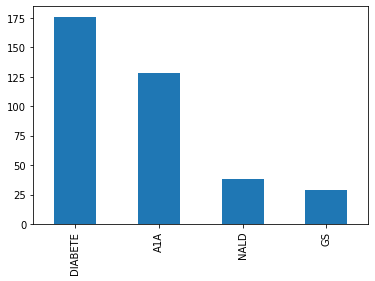

In [118]:
# plotting the number of sample for each disease
disease = df['DISEASE'].value_counts()
print(disease)
disease.plot.bar()

# Analysis

In [119]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

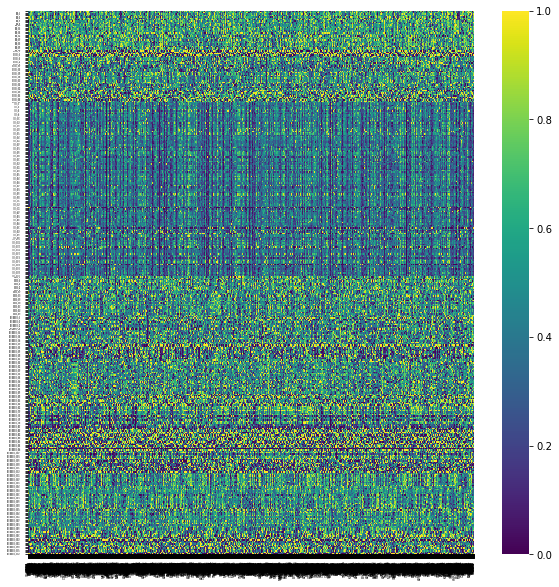

In [55]:
visuz.gene_exp.hmap(df=df[data_cols], cmap='viridis', rowclus=False, colclus=False, dim=(10, 10), tickfont=(3, 2), show=True)

In [ ]:
gene = 'CHST2'
plt.hist(df.loc[df['DISEASE']=='GS', gene], bins=10, alpha=0.5)
#plt.hist(df.loc[df['DISEASE']=='MCM', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='A1A', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='DIABETE', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='NALD', gene], bins=10, alpha=0.5)

plt.title(gene+' gene histogram')  
#plt.legend(['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'])
plt.legend(['GS', 'A1A', 'DIABETE', 'NALD'])
  
plt.show()

## Biomarker Identification pipeline

1. Pairwise statistical test
2. Gene selection for each pair of disease
3. Gene intersection

In [ ]:
from collections.abc import Callable
import itertools
def pairwise_hyp_testing(df: pd.DataFrame, disease_col: str, diseases: list[str], 
                         test: Callable[[pd.Series, pd.Series], float]) -> dict[tuple[str,str], list[float]]:
    """
    This function computes the pairwise hypothesis testing between diseases.
    :param df: dataframe with expression levels
    :param disease_col: the name of the column where the type of disease is represented
    :param diseases: a list of diseases to test
    :param test: the function of the testing
    :return dictionary of pairwise test. Example: ('DIABETE', 'A1A') -> [test_gene1, test_gene2,..., test_geneN]
    """
    combinations = list(itertools.combinations(diseases, 2))
    pairwise_test = dict()
    
    for pair in combinations:
        df1 = df[df[disease_col]==pair[0]].copy()
        df1.drop(disease_col, axis=1, inplace=True)
        df2 = df[df[disease_col]==pair[1]].copy()
        df2.drop(disease_col, axis=1, inplace=True)
        pair_test = []
        
        for gene in df1:
            gene_test = test(df1[gene], df2[gene])
            pair_test.append(gene_test)
        
        pairwise_test[pair] = pair_test
    
    return pairwise_test


In [ ]:
from scipy.stats import ttest_ind
def t_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the t-test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pvalue
    """
    # ttest_ind returns tuple(statistic, pvalue)
    return ttest_ind(s1, s2)[1]

In [ ]:
import math
def log2fc(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the log-fold change between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return log2-Fold Change
    """
    return math.log(s1.mean()/s2.mean(), 2)

In [ ]:
from scipy.stats import ranksums
def wilcoxon_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Wilcoxon's test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of Wilcoxon's test
    """
    return ranksums(s1, s2)[1]

In [ ]:
from scipy.stats import ks_2samp
def ks_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Kolmogorov-Smirnov test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of KS test
    """
    return ks_2samp(s1, s2)[1]

In [ ]:
import math
def gene_selection(stat_test: dict[tuple[str,str], list[float]], gene_names: list[str], 
                   alpha: float, correction: str = None, log2fc: dict[tuple[str,str], list[float]] = None,
                  log2fc_thr: float = None)-> dict[tuple[str,str], list[str]]:
    """
    This function selects genes for each pair of diseases based on a given threshold, eventually with correction.
    :param stat_test: dictionary with pvalues of pairwise tests 
                        Example of entry ('Disease1', 'Disease2') -> [pValues_gene1,...,pValues_geneN]
    :param gene_names: list of gene names. This list MUST have the same length of each value of the dictionary
                        and the same order
    :param alpha: the significance to test the pValue
    :param correction: type of correction to apply to the filter. 
                        Possible values ['bonferroni', '2fc', None]
                        'bonferroni': Bonferroni correction
                        '2fc': log2FC - pValue selection. It requires log2fc and log2fc_thr parameters
                        None: by default negative log10 comparison
    :param log2fc: dictionary with log2fc of pairwise tests. Needed if correction='2fc'. MUST have the same length
                    and order of gene_names.
    :param log2fc_thr: threshold for log2fc. Needed if correction='2fc'
    :return dictionary with filtered genes by pValues
    """
    a = alpha
    f = lambda pVal: -math.log(pVal,10)
    # Check if you have to compare log2FC with pValue
    volcano = False
    threshold_check = lambda pVal, alpha: pVal > alpha
    
    # Arguments validation
    if correction == 'bonferroni':
        a = f(a/len(stat_test))
    elif correction == '2fc':
        if log2fc == None or log2fc_thr == None:
            raise ValueError("Correction='2fc', you must define log2fc and log2fc_thr")
        else:
            a = f(a)
            threshold_check = lambda pVal, alpha, l2fc, l2fc_thr: pVal > alpha and abs(l2fc) > l2fc_thr
            volcano = True
    else:
        a = f(a)
        
    
    pairwise_genes_dict = {}
    for key, value in stat_test.items():
        selected_genes = []
        # Double comparison log2fc - pvalue
        if volcano:
            curr_log2fc = log2fc[key]
            for i in range(len(value)):
                if threshold_check(f(value[i]), a, curr_log2fc[i], log2fc_thr):
                    selected_genes.append(gene_names[i])
        # Comparison of pvalue
        else: 
            for i in range(len(value)):
                if threshold_check(f(value[i]), a):
                    selected_genes.append(gene_names[i])
        pairwise_genes_dict[key] = selected_genes
    
    return pairwise_genes_dict

In [ ]:
def gene_intersection(pairwise_genes: dict[tuple[str,str], list[str]], verbose: bool = False ) -> list[str]:
    """
    This function computes the intersection between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :param verbose: print the size of each intersection
    :return intersection between genes
    """
    intersection = []
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            intersection = [gene for gene in intersection if gene in value]
        else:
            intersection = value
            first=False
        if verbose:
            print(len(intersection))
    return intersection

## Test

In [ ]:
import itertools
diseases = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
combinations = list(itertools.combinations(diseases, 2))
combinations

In [ ]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist(testing[key], bins=100)
    axs[i].set_title(str(key))
    i += 1

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist([f(pval) for pval in value], bins=100)
    axs[i].set_title(str(key))
    i += 1

In [ ]:
testing_l2fc = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], log2fc)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].scatter(testing_l2fc[key], [f(pval) for pval in value], s=5)
    axs[i].set_title(str(key))
    i += 1

In [ ]:
for key, value in testing.items():
    volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[key], 'pvalue': value})
    visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.1, 0.6), pv_thr=(0.05, 0.05), 
                             figname=str(key), dim=(5,5), sign_line=True, plotlegend=True, show=True)

In [ ]:
f = lambda x: -math.log(x,10)

In [ ]:
volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[('GS','MCM')], 'pvalue': testing[('GS','MCM')]})

In [ ]:
visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.5, 0.5), pv_thr=(0.01, 0.01), 
                             dim=(7,7), sign_line=True, plotlegend=True, show=True)

## Merging test

In [ ]:
# Discutere sul perché se faccio pvalue < 0.05 l'intersection è vuota
# Mentre se trasformo tutto in log10 l'intersection non è vuota
# Discutere se va fatto pValue < alpha o pValue > alpha
# In caso di log10 pValue > alpha, senza

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, '2fc', testing_l2fc, 0.1)

In [ ]:
intersection = gene_intersection(genes_dict)

In [ ]:
len(intersection)

# T-test

In [ ]:
for dis in ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']:
    tmp = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
    tmp.remove(dis)
    testing = pairwise_hyp_testing(df, 'DISEASE', tmp, t_test)
    data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
    genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')
    intersection = gene_intersection(genes_dict)
    print(dis+': '+str(len(intersection)))

In [ ]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'A1A', 'DIABETE', 'NALD'], t_test)

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [ ]:
intersection = gene_intersection(genes_dict, verbose=True)

In [ ]:
len(intersection)

# Wilcoxon test

In [ ]:
for dis in ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']:
    tmp = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
    tmp.remove(dis)
    testing = pairwise_hyp_testing(df, 'DISEASE', tmp, wilcoxon_test)
    data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
    genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')
    intersection = gene_intersection(genes_dict)
    print(dis+': '+str(len(intersection)))

In [ ]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'A1A', 'DIABETE', 'NALD'], wilcoxon_test)

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [ ]:
intersection = gene_intersection(genes_dict, verbose=True)

In [ ]:
len(intersection)

# KS test

In [ ]:
for dis in ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']:
    tmp = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
    tmp.remove(dis)
    testing = pairwise_hyp_testing(df, 'DISEASE', tmp, ks_test)
    data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
    genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')
    intersection = gene_intersection(genes_dict)
    print(dis+': '+str(len(intersection)))

In [ ]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'A1A', 'DIABETE', 'NALD'], ks_test)

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [ ]:
intersection = gene_intersection(genes_dict, verbose=True)

In [136]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'A1A', 'DIABETE', 'NALD'], ks_test)

In [137]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [138]:
intersection = gene_intersection(genes_dict, verbose=True)

4620
1589
803
732
488
49


In [139]:
len(intersection)

49